In [48]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import json, os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tf.config.list_physical_devices('GPU') 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

DATAPATH = os.path.abspath('../../data/')

1 Physical GPUs, 1 Logical GPUs


In [56]:
vocab_size = 2500
embedding_dim = 150
max_length = 1000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [57]:
with open(os.path.join(DATAPATH, "sarcasm.json"), 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [58]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [59]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [60]:
# Need this block to get it to work with TensorFlow 2.x
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [61]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 150)         375000    
_________________________________________________________________
global_average_pooling1d_9 ( (None, 150)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 24)                3624      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 25        
Total params: 378,649
Trainable params: 378,649
Non-trainable params: 0
_________________________________________________________________


In [64]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 9s - loss: 0.2678 - accuracy: 0.8834 - val_loss: 0.4529 - val_accuracy: 0.8058
Epoch 2/30
625/625 - 9s - loss: 0.2727 - accuracy: 0.8788 - val_loss: 0.3902 - val_accuracy: 0.8301
Epoch 3/30
625/625 - 9s - loss: 0.2713 - accuracy: 0.8832 - val_loss: 0.3893 - val_accuracy: 0.8307
Epoch 4/30
625/625 - 9s - loss: 0.2671 - accuracy: 0.8850 - val_loss: 0.4098 - val_accuracy: 0.8246
Epoch 5/30
625/625 - 9s - loss: 0.2686 - accuracy: 0.8844 - val_loss: 0.3960 - val_accuracy: 0.8307
Epoch 6/30
625/625 - 9s - loss: 0.2693 - accuracy: 0.8837 - val_loss: 0.3947 - val_accuracy: 0.8307
Epoch 7/30
625/625 - 9s - loss: 0.2662 - accuracy: 0.8839 - val_loss: 0.4594 - val_accuracy: 0.8056
Epoch 8/30
625/625 - 9s - loss: 0.2698 - accuracy: 0.8852 - val_loss: 0.3978 - val_accuracy: 0.8295
Epoch 9/30
625/625 - 9s - loss: 0.2681 - accuracy: 0.8856 - val_loss: 0.4179 - val_accuracy: 0.8198
Epoch 10/30
625/625 - 9s - loss: 0.2675 - accuracy: 0.8842 - val_loss: 0.3979 - val_accuracy: 0.8293

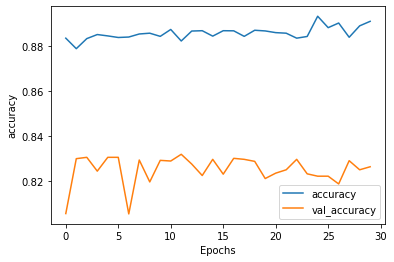

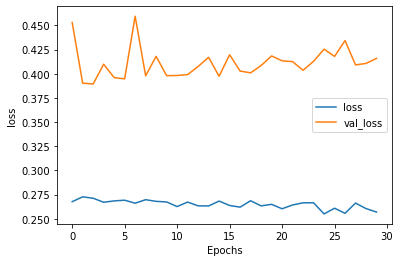

In [65]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")